In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import pandas as pd
import cst
import pyaldata

import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


# Speficy whether or not to save figures
save_figures = False

In [2]:
filename = '/data/raeed/project-data/smile/cst-gainlag/library/python/Ford_20180618_COCST_TD.mat'
# td = cst.get_cst_dataframe(filename)
td = pyaldata.mat2dataframe(filename,True,'td_cst')
td.set_index('trial_id',inplace=True)

In [4]:
cursor_pos = td.loc[151,'cursor_pos']
cursor_vel = td.loc[151,'cursor_vel']

np.column_stack((cursor_pos[:,1],cursor_vel[:,1]))

array([[469.17173627,  11.00291774],
       [469.21195343,  36.83392798],
       [469.24540413,  29.13944929],
       ...,
       [576.18223602,   8.08692442],
       [576.19026113,   7.81268671],
       [576.19786139,   7.25338698]])

In [45]:
np.unique(td['lambda'])
lambda_to_use = 3.3
td_lambda = td[td['lambda']==lambda_to_use]
control_obs = [el[:,0][:,None] for el in td_lambda['hand_pos']]
vis_input = [np.column_stack((pos[:,0],vel[:,0]))
            for pos,vel in zip(td_lambda['cursor_pos_shift'],td_lambda['cursor_vel_shift'])]
for trial_id,trial in td_lambda.iterrows():
    display(trial)

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:46:14
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:46:23
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:46:32
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:46:43
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:46:51
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:47:07
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:47:15
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:47:24
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:47:32
result                                                                   F
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          1.0
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:47:39
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:47:48
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:48:01
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:48:09
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:48:19
result                                                                   R
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:48:29
result                                                                   F
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:48:34
result                                                                   F
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          NaN
idx_cstStartTime                                                         0
idx_cstEndTime           

monkey                                                                Ford
task                                                                   CST
date_time                                              2018/06/18 08:48:39
result                                                                   F
bin_size                                                             0.001
lambda                                                                 3.3
ct_location                                                  [0, 470, 100]
ot_location                                                            NaN
cursor_pos_shift_vals                                                 -100
cursor_vel_shift_vals                                                 -100
idx_ctHoldTime                                                         NaN
idx_goCueTime                                                          0.0
idx_cstStartTime                                                         0
idx_cstEndTime           

  0%|          | 0/50 [00:00<?, ?it/s]

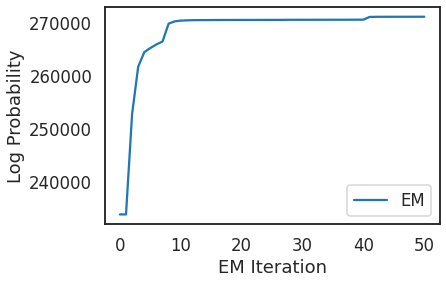

In [104]:
num_states = 3
obs_dim = 1
input_dims = 2
N_iters = 50

lambda_to_use = 3.3
td_lambda = td[td['lambda']==lambda_to_use]
control_obs = [el[:,0][:,None] for el in td_lambda['hand_pos']]
vis_input = [np.column_stack((pos[:,0],vel[:,0]))
            for pos,vel in zip(td_lambda['cursor_pos_shift'],td_lambda['cursor_vel_shift'])]

hmm = ssm.HMM(num_states, obs_dim, M=input_dims, observations="autoregressive",transitions='recurrent_only')

hmm_lls = hmm.fit(control_obs, inputs=vis_input, method="em", num_iters=N_iters, init_method="kmeans") #can also use random for initialization method, which sometimes works better

# make plots
plt.plot(hmm_lls, label="EM")
plt.xlabel("EM Iteration")
plt.ylabel("Log Probability")
plt.legend(loc="lower right")
plt.show()

In [113]:
from ipywidgets import interact

@interact(trial_id=list(td_lambda.index),scale=(10,60))
def plot_cst_trial(trial_id,scale):
    trial = td_lambda.loc[trial_id,:]
    
    # Plot the true and inferred discrete states
    hmm_z = hmm.most_likely_states(
        trial['hand_pos'][:,0][:,None],
        input=np.column_stack((trial['cursor_pos'][:,0],trial['cursor_vel'][:,0])),
        )

    plt.figure(figsize=(10,10))
    plt.subplot(221)
    plt.plot([-60,60],[60,-60],'--k')
    plt.plot([0,0],[-60,60],'-k')
    plt.plot([-60,60],[0,0],'-k')
    plt.scatter(trial['cursor_pos'][:,0],trial['hand_pos'][:,0],c=hmm_z,cmap=cmap,s=10)
    plt.xlim(-scale,scale)
    plt.ylim(-scale,scale)
    plt.xlabel('Cursor pos')
    plt.ylabel('Hand pos')
    
    plt.subplot(222)
    plt.imshow(hmm_z[None,:],
               aspect="auto",
               cmap=cmap,
               vmin=0,
               vmax=len(colors)-1,
               extent=(0, trial['hand_pos'].shape[0], -scale, scale))

    plt.plot(trial['hand_pos'][:,0], '-k')
    plt.xlim(0, trial['hand_pos'].shape[0])
    plt.xlabel("time")
    plt.ylim(-scale,scale)
    plt.title("Hand pos")
    plt.tight_layout()
    
    plt.figure(figsize=(12,12))
    plt.subplot(223)
    plt.plot([0,0],[-100,100],'-k')
    plt.plot([-60,60],[0,0],'-k')
    plt.scatter(trial['cursor_pos_shift'][:,0],trial['cursor_vel_shift'][:,0],c=hmm_z,cmap=cmap,s=10)
    plt.xlim(-scale,scale)
    plt.ylim(-100,100)
    plt.xlabel('Cursor pos')
    plt.ylabel('Cursor vel')

interactive(children=(Dropdown(description='trial_id', options=(151, 152, 153, 154, 155, 158, 159, 160, 161, 1…

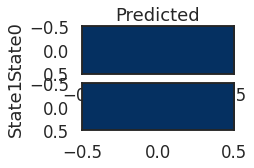

In [76]:
for i in range(num_states):
    plt.subplot(4,2,2*i+2)
    plt.imshow(hmm.observations.As[i],aspect='auto',cmap='RdBu',clim=[-1,1])
    if i==0:
        plt.title('Predicted')
    plt.ylabel('State'+str(i))


In [100]:
hmm.transitions.Ws

array([[ 0.00850529,  0.00052714],
       [-0.00850529, -0.00052714]])